# U.S. Business Cycle Data

This notebook downloads, manages, and exports several data series for studying business cycles in the US. Four files are created in the `csv` directory:

File name                                    | Description                                          |
---------------------------------------------|------------------------------------------------------|
`rbc_data_actual_trend.csv`                  | RBC data with actual and trend values                |
`rbc_data_actual_trend_cycle.csv`            | RBC data with actual, trend, and cycle values        |
`business_cycle_data_actual_trend.csv`       | Larger data set with actual and trend values         |
`business_cycle_data_actual_trend_cycle.csv` | Larger data set with actual, trend, and cycle values |

The first two files are useful for studying basic RBC models. The second two contain all of the RBC data plus money, inflation, and inflation data.

In [1]:
import pandas as pd
import numpy as np
import fredpy as fp
import matplotlib.pyplot as plt

plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
# Export path: Set to empty string '' if you want to export data to current directory
export_path = '../Csv/'

In [3]:
# Load FRED API key
fp.api_key = fp.load_api_key('fred_api_key.txt')

## Download and manage data

Download the following series from FRED:

FRED series ID | Name | Frequency |
---------------|------|-----------|
GDP | Gross Domestic Product | Q |
PCEC | Personal Consumption Expenditures | Q |
GPDI | Gross Private Domestic Investment | Q |
GCE | Government Consumption Expenditures and Gross Investment | Q |
EXPGS | Exports of Goods and Services | Q |
IMPGS | Imports of Goods and Services | Q |
NETEXP | Net Exports of Goods and Services | Q |
HOANBS | Nonfarm Business Sector: Hours Worked for All Employed Persons | Q |
GDPDEF | Gross Domestic Product: Implicit Price Deflator | Q |
PCECTPI | Personal Consumption Expenditures: Chain-type Price Index | Q |
CPIAUCSL | Consumer Price Index for All Urban Consumers: All Items in U.S. City Average | M |
M2SL | M2 | M |
TB3MS | 3-Month Treasury Bill Secondary Market Rate | M |
UNRATE | Unemployment Rate | M |

Monthly series (M2, T-Bill, unemployment rate) are converted to quarterly frequencies. CPI and PCE inflation rates are computed as the percent change in the indices over the previous year. GDP, consumption, investment, government expenditures, net exports and M2 are deflated by the GDP deflator. The data ranges for nataional accounts series (GDP, consumption, investment, government expenditures, net exports) and hours are equalized to the largest common date range. 

In [4]:
# Download data
gdp = fp.series('GDP')
consumption = fp.series('PCEC')
investment = fp.series('GPDI')
government = fp.series('GCE')
exports = fp.series('EXPGS')
imports = fp.series('IMPGS')
net_exports = fp.series('NETEXP')
hours = fp.series('HOANBS')
deflator = fp.series('GDPDEF')
pce_deflator = fp.series('PCECTPI')
cpi = fp.series('CPIAUCSL')
m2 = fp.series('M2SL')
tbill_3mo = fp.series('TB3MS')
unemployment = fp.series('UNRATE')

# Base year for NIPA deflators
cpi_base_year = cpi.units.split(' ')[1].split('=')[0]

# Base year for CPI
nipa_base_year = deflator.units.split(' ')[1].split('=')[0]

# Convert monthly M2, 3-mo T-Bill, and unemployment to quarterly
m2 = m2.as_frequency('Q')
tbill_3mo = tbill_3mo.as_frequency('Q')
unemployment = unemployment.as_frequency('Q')
cpi = cpi.as_frequency('Q')

# Deflate GDP, consumption, investment, government expenditures, net exports, and m2 with the GDP deflator
def deflate(series,deflator):
    
    deflator, series = fp.window_equalize([deflator, series])
    series = series.divide(deflator).times(100)
    
    return series

gdp = deflate(gdp,deflator)
consumption = deflate(consumption,deflator)
investment = deflate(investment,deflator)
government = deflate(government,deflator)
net_exports = deflate(net_exports,deflator)
exports = deflate(exports,deflator)
imports = deflate(imports,deflator)
m2 = deflate(m2,deflator)

# pce inflation as percent change over past year
pce_deflator = pce_deflator.apc()

# cpi inflation as percent change over past year
cpi = cpi.apc()

# GDP deflator inflation as percent change over past year
deflator = deflator.apc()

# Convert unemployment, 3-mo T-Bill, pce inflation, cpi inflation, GDP deflator inflation data to rates 
unemployment = unemployment.divide(100)
tbill_3mo = tbill_3mo.divide(100)
pce_deflator = pce_deflator.divide(100)
cpi = cpi.divide(100)
deflator = deflator.divide(100)

# Make sure that the RBC data has the same data range
gdp,consumption,investment,government,exports,imports,net_exports,hours = fp.window_equalize([gdp,consumption,investment,government,exports,imports,net_exports,hours])

# T-Bill data doesn't neet to go all the way back to 1930s
tbill_3mo = tbill_3mo.window([gdp.data.index[0],'2222'])

In [5]:
metadata = pd.Series(dtype=str,name='Values')
metadata['nipa_base_year'] = nipa_base_year
metadata['cpi_base_year'] = cpi_base_year

metadata.to_csv(export_path+'/business_cycle_metadata.csv')

## Compute capital stock for US using the perpetual inventory method

Next, compute the quarterly capital stock series for the US using the perpetual inventory method. The discrete-time Solow growth model is given by:

\begin{align}
Y_t & = A_tK_t^{\alpha}L_t^{1-\alpha} \tag{1}\\
C_t & = (1-s)Y_t \tag{2}\\
Y_t & = C_t + I_t \tag{3}\\
K_{t+1} & = I_t + (1-\delta)K_t \tag{4}\\
A_{t+1} & = (1+g)A_t \tag{5}\\
L_{t+1} & = (1+n)L_t \tag{6}.
\end{align}

Here the model is assumed to be quarterly so $n$ is the *quarterly* growth rate of labor hours, $g$ is the *quarterly* growth rate of TFP, and $\delta$ is the *quarterly* rate of depreciation of the capital stock. Given a value of the quarterly depreciation rate $\delta$, an investment series $I_t$, and an initial capital stock $K_0$, the law of motion for the capital stock, Equation (4), can be used to compute an implied capital series. But we don't know $K_0$ or $\delta$ so we'll have to *calibrate* these values using statistics computed from the data that we've already obtained.

Let lowercase letters denote a variable that's been divided by $A_t^{1/(1-\alpha)}L_t$. E.g.,

\begin{align}
y_t = \frac{Y_t}{A_t^{1/(1-\alpha)}L_t}\tag{7}
\end{align}

Then (after substituting consumption from the model), the scaled version of the model can be written as: 

\begin{align}
y_t & = k_t^{\alpha} \tag{8}\\
i_t & = sy_t \tag{9}\\
k_{t+1} & = i_t + (1-\delta-n-g')k_t,\tag{10}
\end{align}

where $g' = g/(1-\alpha)$ is the growth rate of $A_t^{1/(1-\alpha)}$. In the steady state:

\begin{align}
k & = \left(\frac{s}{\delta+n+g'}\right)^{\frac{1}{1-\alpha}} \tag{11}
\end{align}

which means that the ratio of capital to output is constant:

\begin{align}
\frac{k}{y} & = \frac{s}{\delta+n+g'} \tag{12}
\end{align}

and therefore the steady state ratio of depreciation to output is:

\begin{align}
\overline{\delta K/ Y} & = \frac{\delta s}{\delta + n + g'} \tag{13}
\end{align}

where $\overline{\delta K/ Y}$ is the long-run average ratio of depreciation to output. We can use Equation (13) to calibrate $\delta$ given $\overline{\delta K/ Y}$, $s$, $n$, and $g'$.

Furthermore, in the steady state, the growth rate of output is constant:

\begin{align}
\frac{\Delta Y}{Y} & = n + g' \tag{14}
\end{align} 


1. Assume $\alpha = 0.35$.
2. Calibrate $s$ as the average of ratio of investment to GDP.
3. Calibrate $n$ as the average quarterly growth rate of labor hours.
4. Calibrate $g'$ as the average quarterly growth rate of real GDP minus n.
5. Calculate the average ratio of depreciation to GDP $\overline{\delta K/ Y}$ and use the result to calibrate $\delta$. That is, find the average ratio of Current-Cost Depreciation of Fixed Assets (FRED series ID: M1TTOTL1ES000) to GDP (FRED series ID: GDPA). Then calibrate $\delta$ from the following steady state relationship:
\begin{align}
\delta & = \frac{\left( \overline{\delta K/ Y} \right)\left(n + g' \right)}{s - \left( \overline{\delta K/ Y} \right)} \tag{15}
\end{align}
6. Calibrate $K_0$ by asusming that the capital stock is initially equal to its steady state value:
\begin{align}
K_0 & = \left(\frac{s}{\delta + n + g'}\right) Y_0 \tag{16}
\end{align}

Then, armed with calibrated values for $K_0$ and $\delta$, compute $K_1, K_2, \ldots$ recursively. See Timothy Kehoe's notes for more information on the perpetual inventory method:

http://users.econ.umn.edu/~tkehoe/classes/GrowthAccountingNotes.pdf



In [6]:
# Set the capital share of income
alpha = 0.35

# Average saving rate
s = np.mean(investment.data/gdp.data)

# Average quarterly labor hours growth rate
n = (hours.data.iloc[-1]/hours.data.iloc[0])**(1/(len(hours.data)-1)) - 1

# Average quarterly real GDP growth rate
g = ((gdp.data.iloc[-1]/gdp.data.iloc[0])**(1/(len(gdp.data)-1)) - 1) - n

## Compute annual depreciation rate

# Download annual gdp and depreciation data
depA = fp.series('M1TTOTL1ES000')
gdpA = fp.series('gdpa')

# Divide depreciation data by 1000 to change units from millions of $ to billions of $
depA = depA.divide(1000)

gdpA = gdpA.window([gdp.data.index[0],gdp.data.index[-1]])
gdpA,depA = fp.window_equalize([gdpA,depA])

deltaKY = np.mean(depA.data/gdpA.data)
delta = (n+g)*deltaKY/(s-deltaKY)

# print calibrated values:
print('Avg saving rate:        ',round(s,5))
print('Avg annual labor growth:',round(4*n,5))
print('Avg annual gdp growth:  ',round(4*g,5))
print('Avg annual dep rate:    ',round(4*delta,5))

# Construct the capital series. Note that the GPD and investment data are reported on an annualized basis
# so divide by 4 to get quarterly data.
capital = np.zeros(len(gdp.data))
capital[0] = gdp.data.iloc[0]/4*s/(n+g+delta)

for t in range(len(gdp.data)-1):
    capital[t+1] = investment.data.iloc[t]/4 + (1-delta)*capital[t]

# Save in a fredpy series
capital = fp.to_fred_series(data = capital,dates =gdp.data.index,units = gdp.units,title='Capital stock of the US',frequency='Quarterly')

Avg saving rate:         0.17368
Avg annual labor growth: 0.01196
Avg annual gdp growth:   0.01863
Avg annual dep rate:     0.13182


## Compute total factor productivity

Use the Cobb-Douglas production function:

\begin{align}
Y_t & = A_tK_t^{\alpha}L_t^{1-\alpha} \tag{17}
\end{align}

and data on GDP, capital, and hours with $\alpha=0.35$ to compute an implied series for $A_t$.

In [7]:
# Compute TFP
tfp = gdp.data/capital.data**alpha/hours.data**(1-alpha)
tfp = fp.to_fred_series(data = tfp,dates =gdp.data.index,units = gdp.units,title='TFP of the US',frequency='Quarterly')

## Additional data management

Now that we have used the aggregate production data to compute an implied capital stock and TFP, we can scale the production data and M2 by the population.

In [8]:
# Convert real GDP, consumption, investment, government expenditures, net exports and M2
# into thousands of dollars per civilian 16 and over
gdp = gdp.per_capita(civ_pop=True).times(1000)
consumption = consumption.per_capita(civ_pop=True).times(1000)
investment = investment.per_capita(civ_pop=True).times(1000)
government = government.per_capita(civ_pop=True).times(1000)
exports = exports.per_capita(civ_pop=True).times(1000)
imports = imports.per_capita(civ_pop=True).times(1000)
net_exports = net_exports.per_capita(civ_pop=True).times(1000)
hours = hours.per_capita(civ_pop=True).times(1000)
capital = capital.per_capita(civ_pop=True).times(1000)
m2 = m2.per_capita(civ_pop=True).times(1000)


# Scale hours per person to equal 100 on October (Quarter III) of GDP deflator base year.
hours.data = hours.data/hours.data.loc[nipa_base_year+'-10-01']*100

## Plot aggregate data

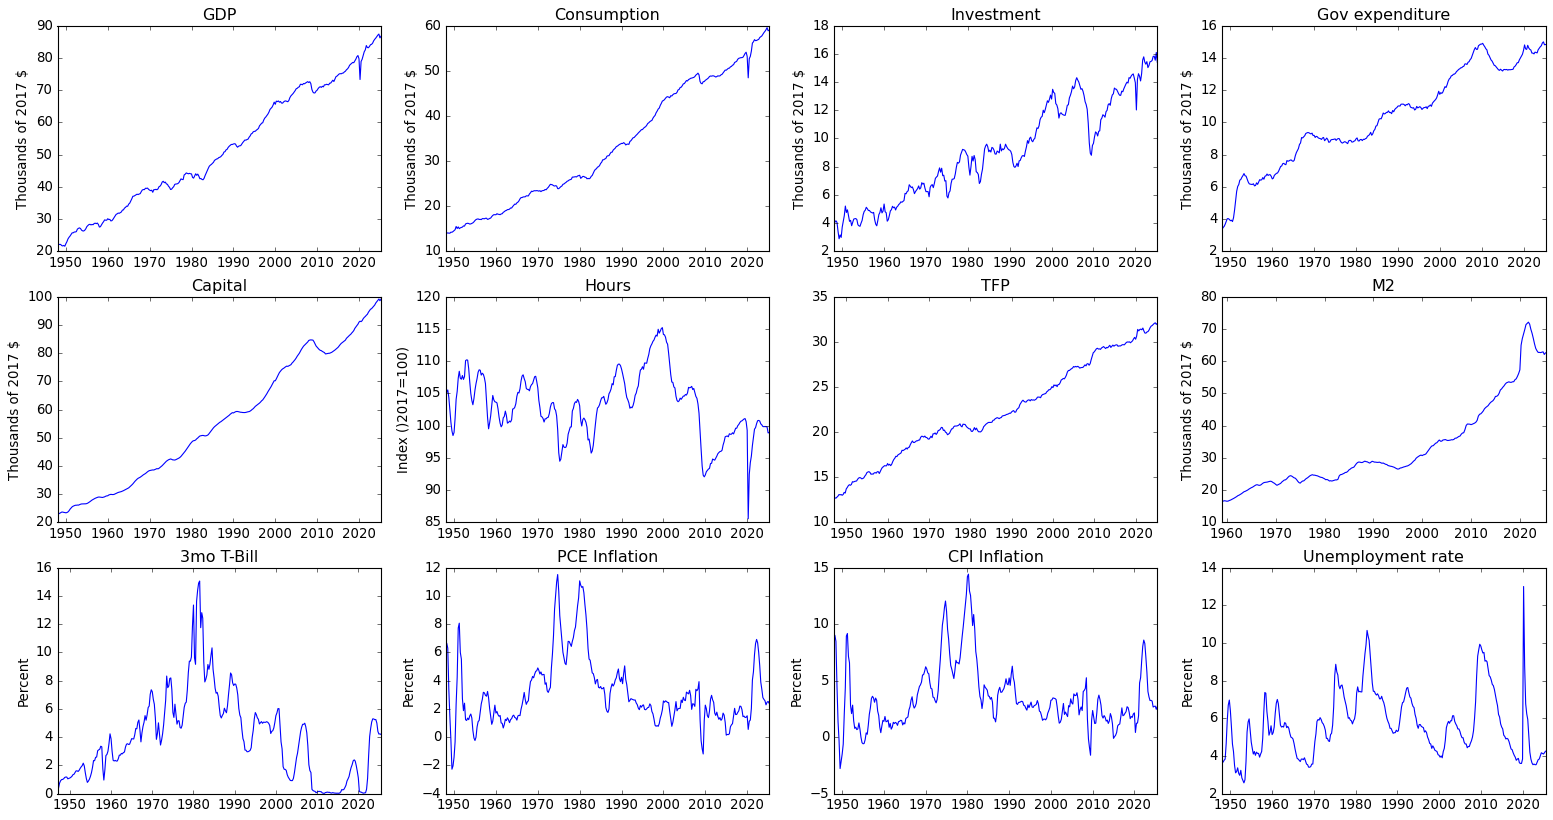

In [9]:
fig, axes = plt.subplots(3,4,figsize=(6*4,4*3))

axes[0][0].plot(gdp.data)
axes[0][0].set_title('GDP')
axes[0][0].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[0][1].plot(consumption.data)
axes[0][1].set_title('Consumption')
axes[0][1].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[0][2].plot(investment.data)
axes[0][2].set_title('Investment')
axes[0][2].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[0][3].plot(government.data)
axes[0][3].set_title('Gov expenditure')
axes[0][3].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[1][0].plot(capital.data)
axes[1][0].set_title('Capital')
axes[1][0].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[1][1].plot(hours.data)
axes[1][1].set_title('Hours')
axes[1][1].set_ylabel('Index ()'+nipa_base_year+'=100)')

axes[1][2].plot(tfp.data)
axes[1][2].set_title('TFP')

axes[1][3].plot(m2.data)
axes[1][3].set_title('M2')
axes[1][3].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[2][0].plot(tbill_3mo.data*100)
axes[2][0].set_title('3mo T-Bill')
axes[2][0].set_ylabel('Percent')

axes[2][1].plot(pce_deflator.data*100)
axes[2][1].set_title('PCE Inflation')
axes[2][1].set_ylabel('Percent')

axes[2][2].plot(cpi.data*100)
axes[2][2].set_title('CPI Inflation')
axes[2][2].set_ylabel('Percent')

axes[2][3].plot(unemployment.data*100)
axes[2][3].set_title('Unemployment rate')
axes[2][3].set_ylabel('Percent');

## Compute HP filter of data

In [10]:
# HP filter to isolate trend and cyclical components
gdp_log_cycle,gdp_log_trend= gdp.log().hp_filter()
consumption_log_cycle,consumption_log_trend= consumption.log().hp_filter()
investment_log_cycle,investment_log_trend= investment.log().hp_filter()
government_log_cycle,government_log_trend= government.log().hp_filter()
exports_log_cycle,exports_log_trend= exports.log().hp_filter()
imports_log_cycle,imports_log_trend= imports.log().hp_filter()
# net_exports_log_cycle,net_exports_log_trend= net_exports.log().hp_filter()
capital_log_cycle,capital_log_trend= capital.log().hp_filter()
hours_log_cycle,hours_log_trend= hours.log().hp_filter()
tfp_log_cycle,tfp_log_trend= tfp.log().hp_filter()
deflator_cycle,deflator_trend= deflator.hp_filter()
pce_deflator_cycle,pce_deflator_trend= pce_deflator.hp_filter()
cpi_cycle,cpi_trend= cpi.hp_filter()
m2_log_cycle,m2_log_trend= m2.log().hp_filter()
tbill_3mo_cycle,tbill_3mo_trend= tbill_3mo.hp_filter()
unemployment_cycle,unemployment_trend= unemployment.hp_filter()

## Plot aggregate data with trends

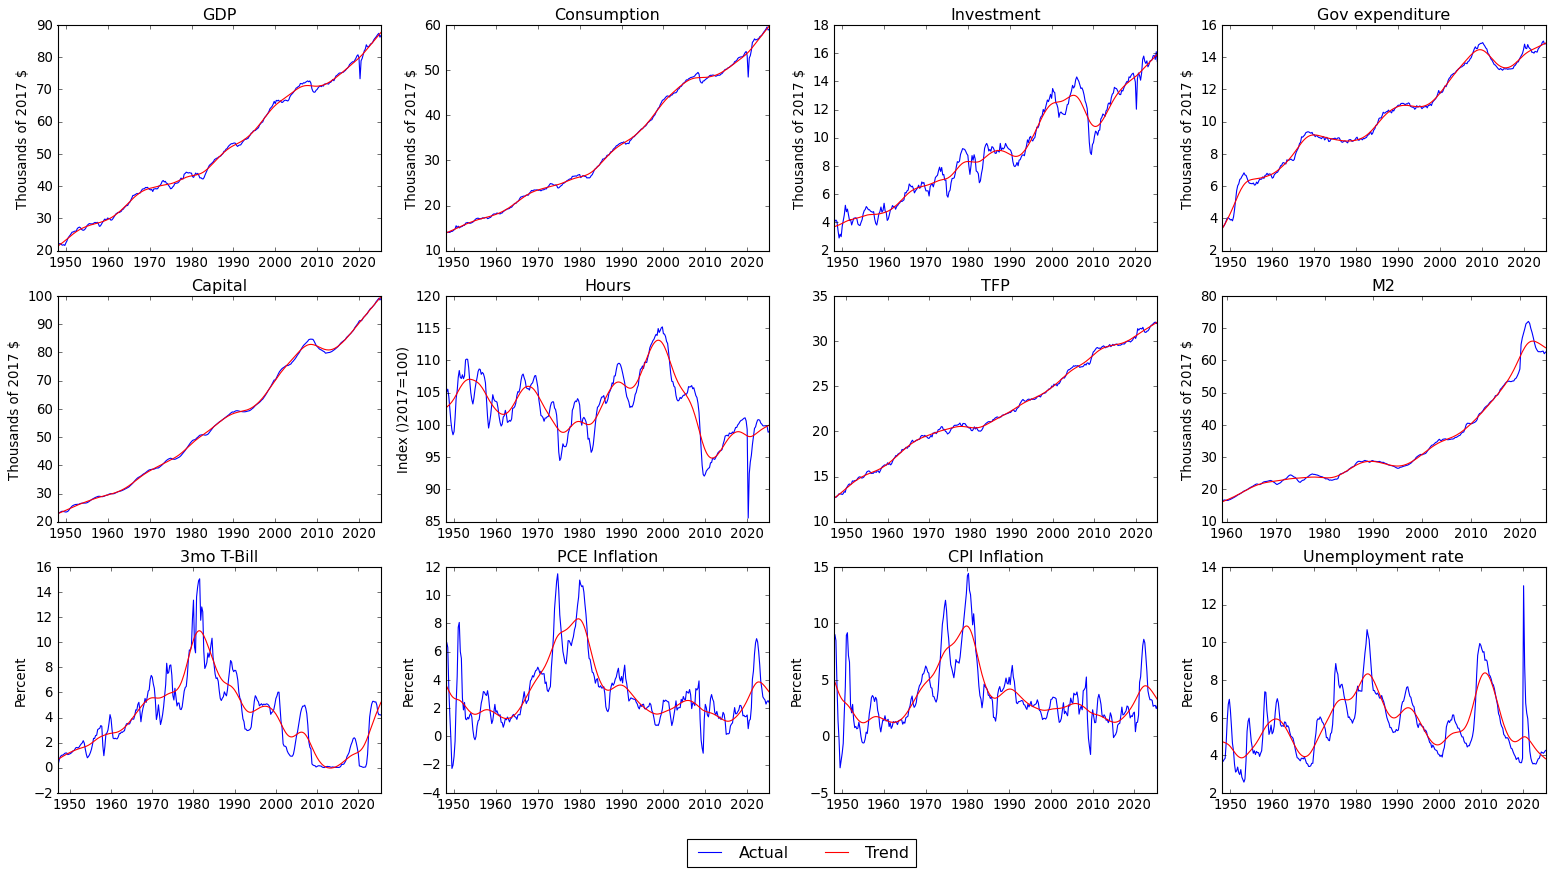

In [11]:
fig, axes = plt.subplots(3,4,figsize=(6*4,4*3))

axes[0][0].plot(gdp.data)
axes[0][0].plot(np.exp(gdp_log_trend.data),c='r')
axes[0][0].set_title('GDP')
axes[0][0].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[0][1].plot(consumption.data)
axes[0][1].plot(np.exp(consumption_log_trend.data),c='r')
axes[0][1].set_title('Consumption')
axes[0][1].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[0][2].plot(investment.data)
axes[0][2].plot(np.exp(investment_log_trend.data),c='r')
axes[0][2].set_title('Investment')
axes[0][2].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[0][3].plot(government.data)
axes[0][3].plot(np.exp(government_log_trend.data),c='r')
axes[0][3].set_title('Gov expenditure')
axes[0][3].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[1][0].plot(capital.data)
axes[1][0].plot(np.exp(capital_log_trend.data),c='r')
axes[1][0].set_title('Capital')
axes[1][0].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[1][1].plot(hours.data)
axes[1][1].plot(np.exp(hours_log_trend.data),c='r')
axes[1][1].set_title('Hours')
axes[1][1].set_ylabel('Index ()'+nipa_base_year+'=100)')

axes[1][2].plot(tfp.data)
axes[1][2].plot(np.exp(tfp_log_trend.data),c='r')
axes[1][2].set_title('TFP')

axes[1][3].plot(m2.data)
axes[1][3].plot(np.exp(m2_log_trend.data),c='r')
axes[1][3].set_title('M2')
axes[1][3].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[2][0].plot(tbill_3mo.data*100)
axes[2][0].plot(tbill_3mo_trend.data*100,c='r')
axes[2][0].set_title('3mo T-Bill')
axes[2][0].set_ylabel('Percent')

axes[2][1].plot(pce_deflator.data*100)
axes[2][1].plot(pce_deflator_trend.data*100,c='r')
axes[2][1].set_title('PCE Inflation')
axes[2][1].set_ylabel('Percent')

axes[2][2].plot(cpi.data*100)
axes[2][2].plot(cpi_trend.data*100,c='r')
axes[2][2].set_title('CPI Inflation')
axes[2][2].set_ylabel('Percent')

axes[2][3].plot(unemployment.data*100)
axes[2][3].plot(unemployment_trend.data*100,c='r')
axes[2][3].set_title('Unemployment rate')
axes[2][3].set_ylabel('Percent')


ax = fig.add_subplot(1,1,1)
ax.axis('off')
ax.plot(0,0,label='Actual')
ax.plot(0,0,c='r',label='Trend')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=2)

## Plot cyclical components of the data

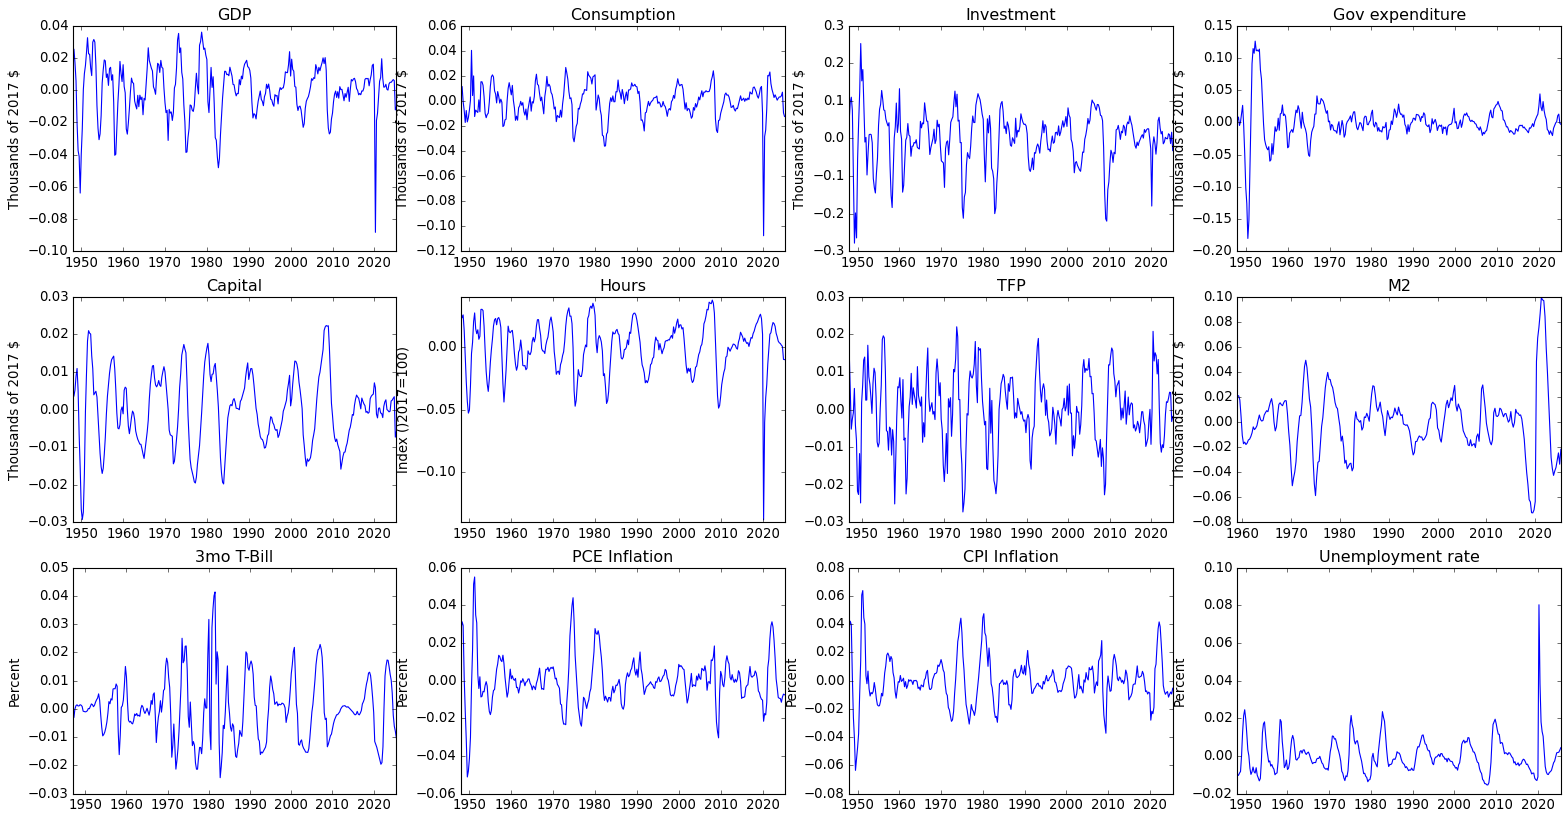

In [12]:
fig, axes = plt.subplots(3,4,figsize=(6*4,4*3))

axes[0][0].plot(gdp_log_cycle.data)
axes[0][0].set_title('GDP')
axes[0][0].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[0][1].plot(consumption_log_cycle.data)
axes[0][1].set_title('Consumption')
axes[0][1].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[0][2].plot(investment_log_cycle.data)
axes[0][2].set_title('Investment')
axes[0][2].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[0][3].plot(government_log_cycle.data)
axes[0][3].set_title('Gov expenditure')
axes[0][3].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[1][0].plot(capital_log_cycle.data)
axes[1][0].set_title('Capital')
axes[1][0].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[1][1].plot(hours_log_cycle.data)
axes[1][1].set_title('Hours')
axes[1][1].set_ylabel('Index ()'+nipa_base_year+'=100)')

axes[1][2].plot(tfp_log_cycle.data)
axes[1][2].set_title('TFP')

axes[1][3].plot(m2_log_cycle.data)
axes[1][3].set_title('M2')
axes[1][3].set_ylabel('Thousands of '+nipa_base_year+' $')

axes[2][0].plot(tbill_3mo_cycle.data)
axes[2][0].set_title('3mo T-Bill')
axes[2][0].set_ylabel('Percent')

axes[2][1].plot(pce_deflator_cycle.data)
axes[2][1].set_title('PCE Inflation')
axes[2][1].set_ylabel('Percent')

axes[2][2].plot(cpi_cycle.data)
axes[2][2].set_title('CPI Inflation')
axes[2][2].set_ylabel('Percent')

axes[2][3].plot(unemployment_cycle.data)
axes[2][3].set_title('Unemployment rate')
axes[2][3].set_ylabel('Percent');

## Create data files

In [13]:
# Create a DataFrame with actual and trend data
data = pd.DataFrame({
        'gdp':gdp.data,
        'gdp_trend':np.exp(gdp_log_trend.data),
        'gdp_cycle':gdp_log_cycle.data,
        'consumption':consumption.data,
        'consumption_trend':np.exp(consumption_log_trend.data),
        'consumption_cycle':consumption_log_cycle.data,
        'investment':investment.data,
        'investment_trend':np.exp(investment_log_trend.data),
        'investment_cycle':investment_log_cycle.data,
        'government':government.data,
        'government_trend':np.exp(government_log_trend.data),
        'government_cycle':government_log_cycle.data,
        'exports':exports.data,
        'exports_trend':np.exp(exports_log_trend.data),
        'exports_cycle':exports_log_cycle.data,
        'imports':imports.data,
        'imports_trend':np.exp(imports_log_trend.data),
        'imports_cycle':imports_log_cycle.data,
        'hours':hours.data,
        'hours_trend':np.exp(hours_log_trend.data),
        'hours_cycle':hours_log_cycle.data,
        'capital':capital.data,
        'capital_trend':np.exp(capital_log_trend.data),
        'capital_cycle':capital_log_cycle.data,
        'tfp':tfp.data,
        'tfp_trend':np.exp(tfp_log_trend.data),
        'tfp_cycle':tfp_log_cycle.data,
        'real_m2':m2.data,
        'real_m2_trend':np.exp(m2_log_trend.data),
        'real_m2_cycle':m2_log_cycle.data,
        't_bill_3mo':tbill_3mo.data,
        't_bill_3mo_trend':tbill_3mo_trend.data,
        't_bill_3mo_cycle':tbill_3mo_cycle.data,
        'cpi_inflation':cpi.data,
        'cpi_inflation_trend':cpi_trend.data,
        'cpi_inflation_cycle':cpi_cycle.data,
        'pce_inflation':pce_deflator.data,
        'pce_inflation_trend':pce_deflator_trend.data,
        'pce_inflation_cycle':pce_deflator_cycle.data,
        'unemployment':unemployment.data,
        'unemployment_trend':unemployment_trend.data,
        'unemployment_cycle':unemployment_cycle.data,
    })

In [14]:
# RBC data
columns_ordered =[]
names = ['gdp','consumption','investment','hours','capital','tfp']
for name in names:
    columns_ordered.append(name)
    columns_ordered.append(name+'_trend')
    
data[columns_ordered].dropna().to_csv(export_path+'rbc_data_actual_trend.csv',index=True)

# Create a DataFrame with actual, trend, and cycle data
columns_ordered =[]
names = ['gdp','consumption','investment','hours','capital','tfp']
for name in names:
    columns_ordered.append(name)
    columns_ordered.append(name+'_trend')
    columns_ordered.append(name+'_cycle')
    
data[columns_ordered].dropna().to_csv(export_path+'rbc_data_actual_trend_cycle.csv',index=True)

In [15]:
# More comprehensive Business Cycle Data
columns_ordered =[]
names = ['gdp','consumption','investment','hours','capital','tfp','real_m2','t_bill_3mo','pce_inflation','unemployment']
for name in names:
    columns_ordered.append(name)
    columns_ordered.append(name+'_trend')

data[columns_ordered].dropna().to_csv(export_path+'business_cycle_data_actual_trend.csv',index=True)

# Create a DataFrame with actual, trend, and cycle data
columns_ordered =[]
names = ['gdp','consumption','investment','hours','capital','tfp','real_m2','t_bill_3mo','pce_inflation','unemployment']
for name in names:
    columns_ordered.append(name)
    columns_ordered.append(name+'_trend')
    columns_ordered.append(name+'_cycle')
    
data[columns_ordered].dropna().to_csv(export_path+'business_cycle_data_actual_trend_cycle.csv')